# Forrest Cover Type Prediction

### w207 Final Project, Spring 2022

Oren Carmeli, Sam Stephens, Stephen Bridwell, Jon Hand.

# Outline

1. Introduction
2. Exploratory Data Analysis (EDA)
3. Baseline Models
4. Generalize Step Optimization 
    + feature engineering
    + hyperparameters
5. Model Comparisons
6. Conclusion
7. Appendix

______________________________________________________________________________________________________________________

# 1) Introduction

### Dataset

The dataset is part of a public competition on [kaggle](https://www.kaggle.com/c/forest-cover-type-prediction/data) that includes recorded attributes of four wilderness areas located in the Roosevelt National Forest of northern Colorado. Each observation (i.e record in the dataset) is a 30m x 30m patch of land. It includes 10 features in raw form (not scaled) as well as binary flags for qualitative independent variables such as wilderness areas and soil type.


### Business Problem
Understanding forest composition is a valuable aspect of managing the health and vitality of our wilderness areas. Classifying cover type can help further research regarding forest fire susceptibility, the spread of the Mountain Pine Beetle infestion, and de-reforestation concerns [[link]](http://cs229.stanford.edu/proj2014/Kevin%20Crain,%20Graham%20Davis,%20Classifying%20Forest%20Cover%20Type%20using%20Cartographic%20Features.pdf).


### Inference Problem

The inference problem is to predict the forest cover type (the predominant kind of tree cover) from strictly cartographic variables (as opposed to remotely sensed data). Specifically, our goal is to build a model that maps the cartographic variables (X) to predict a forecast cover type (Y). The data fields are defined below;

#### Data Fields (X)
- Elevation - Elevation in meters
- Aspect - Aspect in degrees azimuth
- Slope - Slope in degrees
- Horizontal_Distance_To_Hydrology - Horz Dist to nearest surface water features
- Vertical_Distance_To_Hydrology - Vert Dist to nearest surface water features
- Horizontal_Distance_To_Roadways - Horz Dist to nearest roadway
- Hillshade_9am (0 to 255 index) - Hillshade index at 9am, summer solstice
- Hillshade_Noon (0 to 255 index) - Hillshade index at noon, summer solstice
- Hillshade_3pm (0 to 255 index) - Hillshade index at 3pm, summer solstice
- Horizontal_Distance_To_Fire_Points - Horz Dist to nearest wildfire ignition points
- Wilderness_Area (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation
- Soil_Type (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation

#### Data Fields (Y)
- Cover_Type (7 types, integers 1 to 7) - Forest Cover Type designation

The integer cover type value corresponds to the following names;
1. Spruce/Fir
2. Lodgepole Pine
3. Ponderosa Pine
4. Cottonwood/Willow
5. Aspen
6. Douglas-fir
7. Krummholz

# 2) Exploratory Data Analysis (EDA)

### Load Packages

In [105]:
import pandas as pd 
import numpy as np
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression, LinearRegression
import warnings
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import  GradientBoostingClassifier
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, LinearSVC 
from sklearn.neural_network import MLPClassifier

from sklearn import tree
from sklearn.decomposition import PCA, SparsePCA

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import json
import pickle
from IPython.display import Image

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

k_folds = 5
%matplotlib inline

### Create Train, Dev, & Test Objects

In [112]:
np.random.seed(0)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# load data

train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# set up modeling datasets

# X = all but last column 
X_train = np.array(train.iloc[:,:-1])
X_test = np.array(test)

# Y = last column only
Y_train = np.array(train.iloc[:,-1].tolist())

# build dev set based on random subset (20% of train data)
shuffle = np.random.permutation(np.arange(X_train.shape[0]))
X_train, Y_train = X_train[shuffle], Y_train[shuffle]

dev_size = round(X_train.shape[0] * 0.2)
dev_data, dev_labels = X_train[:dev_size], Y_train[:dev_size]
train_data, train_labels = X_train[dev_size:], Y_train[dev_size:]
test_data = X_test

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# set up dataset with cover type names for readible EDA

# append cover type labels
label_categories = ['Spruce/Fir', 
                    'Lodgepole Pine', 
                    'Ponderosa Pine', 
                    'Cottonwood/Willow', 
                    'Aspen',
                    'Douglas-fir',
                    'Krummholz']
label_categories = pd.DataFrame(data = zip(label_categories,list(range(1,8,1))), columns = ['Cover_Type_Name','Cover_Type'])
train_df = train.merge(label_categories, left_on='Cover_Type', right_on='Cover_Type')

# filter to be same subset as in train_data created above
train_df = train_df.iloc[shuffle,:].iloc[dev_size:, :]


# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# show object stats

print('Train Data shape: ', train_data.shape)
print('Train Labels shape: ', train_labels.shape)
print()
print('Dev Data shape: ', dev_data.shape)
print('Dev Labels shape: ', dev_labels.shape)
print()
print('Test Data shape: ', test_data.shape)
print()
print('Column Names: ')
print(train_df.columns)

# check dev split works
#print(f'Dev split check status: {dev_data.shape[0] + train_data.shape[0] == X_train.shape[0]}')

Train Data shape:  (12096, 55)
Train Labels shape:  (12096,)

Dev Data shape:  (3024, 55)
Dev Labels shape:  (3024,)

Test Data shape:  (565892, 55)

Column Names: 
Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil

###  Initial Look of the Dataset

In [111]:
train_df.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type,Cover_Type_Name
7366,9214,3259,354,18,384,134,3783,186,205,155,3570,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,7,Krummholz
4936,6401,3076,123,18,134,21,3294,247,224,98,2520,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,Spruce/Fir
5777,10220,3239,359,19,570,100,2170,188,201,148,190,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,Spruce/Fir
10724,15008,2370,107,17,175,48,201,247,217,92,713,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,Ponderosa Pine
9412,5593,2365,246,27,201,85,532,156,249,223,1839,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,Ponderosa Pine


In [6]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,13608.0,7561.833407,4361.711870,1.0,3783.75,7581.5,11333.25,15120.0
Elevation,13608.0,2750.784465,417.651721,1863.0,2376.00,2752.0,3107.00,3849.0
Aspect,13608.0,156.310259,109.998264,0.0,65.00,125.0,260.00,360.0
Slope,13608.0,16.484641,8.436757,0.0,10.00,15.0,22.00,52.0
Horizontal_Distance_To_Hydrology,13608.0,228.376911,210.430406,0.0,67.00,180.0,330.00,1343.0
Vertical_Distance_To_Hydrology,13608.0,51.300999,61.406202,-146.0,5.00,33.0,79.00,554.0
Horizontal_Distance_To_Roadways,13608.0,1717.970165,1324.621325,0.0,764.00,1318.0,2280.00,6890.0
Hillshade_9am,13608.0,212.755879,30.542749,0.0,196.00,220.0,235.00,254.0
Hillshade_Noon,13608.0,218.993974,22.737076,99.0,207.00,223.0,235.00,254.0
Hillshade_3pm,13608.0,135.074809,45.859581,0.0,106.00,138.0,167.00,248.0


In [105]:
train_df.astype(bool).sum(axis=0).reset_index(name='Non-Zeros')

,index,Non-Zeros
0,Id,12096
1,Elevation,12096
2,Aspect,12007
3,Slope,12091
4,Horizontal_Distance_To_Hydrology,10851
5,Vertical_Distance_To_Hydrology,10605
6,Horizontal_Distance_To_Roadways,12094
7,Hillshade_9am,12095
8,Hillshade_Noon,12096
9,Hillshade_3pm,12025


Wilderness and soil binary flag columns appear significantly more sparse than first 10 variables. 

In [15]:
# distribution of train data labels
train_df['Cover_Type_Name'].value_counts()

Krummholz            1954
Lodgepole Pine       1953
Spruce/Fir           1950
Ponderosa Pine       1949
Cottonwood/Willow    1943
Aspen                1936
Douglas-fir          1923
Name: Cover_Type_Name, dtype: int64

There's an equal presence across all cover types. This helps confirm we will not need to do a stratified sampling for fit and generalize datasets. 

### Deeper Dive Into Feature Variables

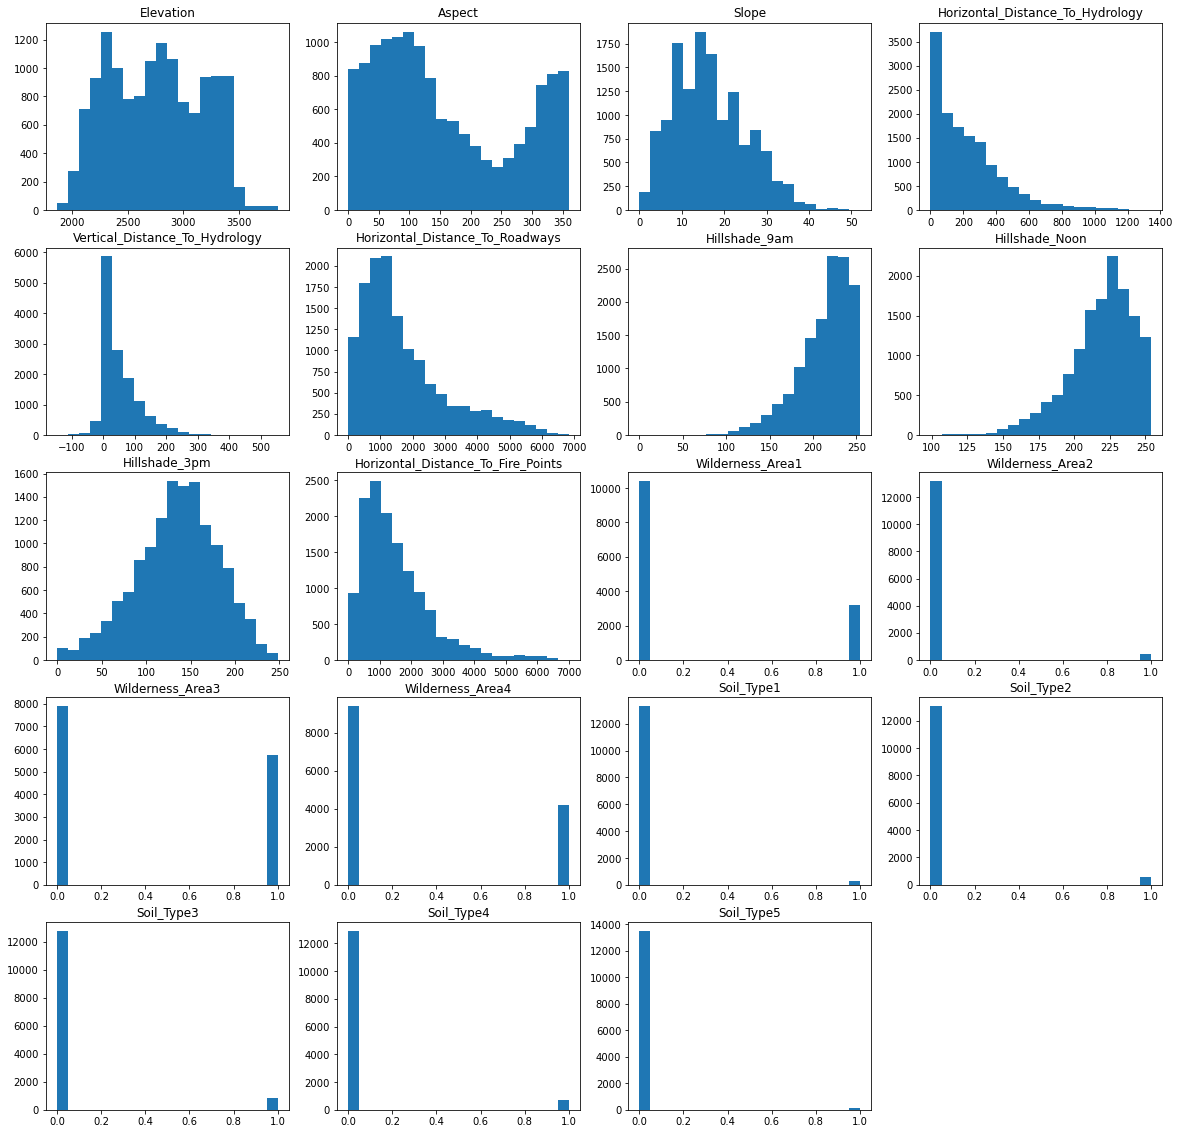

In [7]:
# Create a new figure and set the figsize argument so we get square-ish plots of the 4 features.
plt.figure(figsize=(20, 20))

feature_cols = train_df.columns.tolist()

# Iterate over the features, creating a subplot with a histogram for each one.
for feature in range(1, 20): #train_data.shape[1]
    plt.subplot(5, 4, feature)
    plt.hist(train_data[:,feature], 20)
    plt.title(feature_cols[feature])

The variables outside of the wilderness and soil binary flags all have a generally nice distribution generally spread across their respective ranges. We anticipate the wilderness and soil variables to be relatively sparse and likely good candidates for dimensionality reduction.

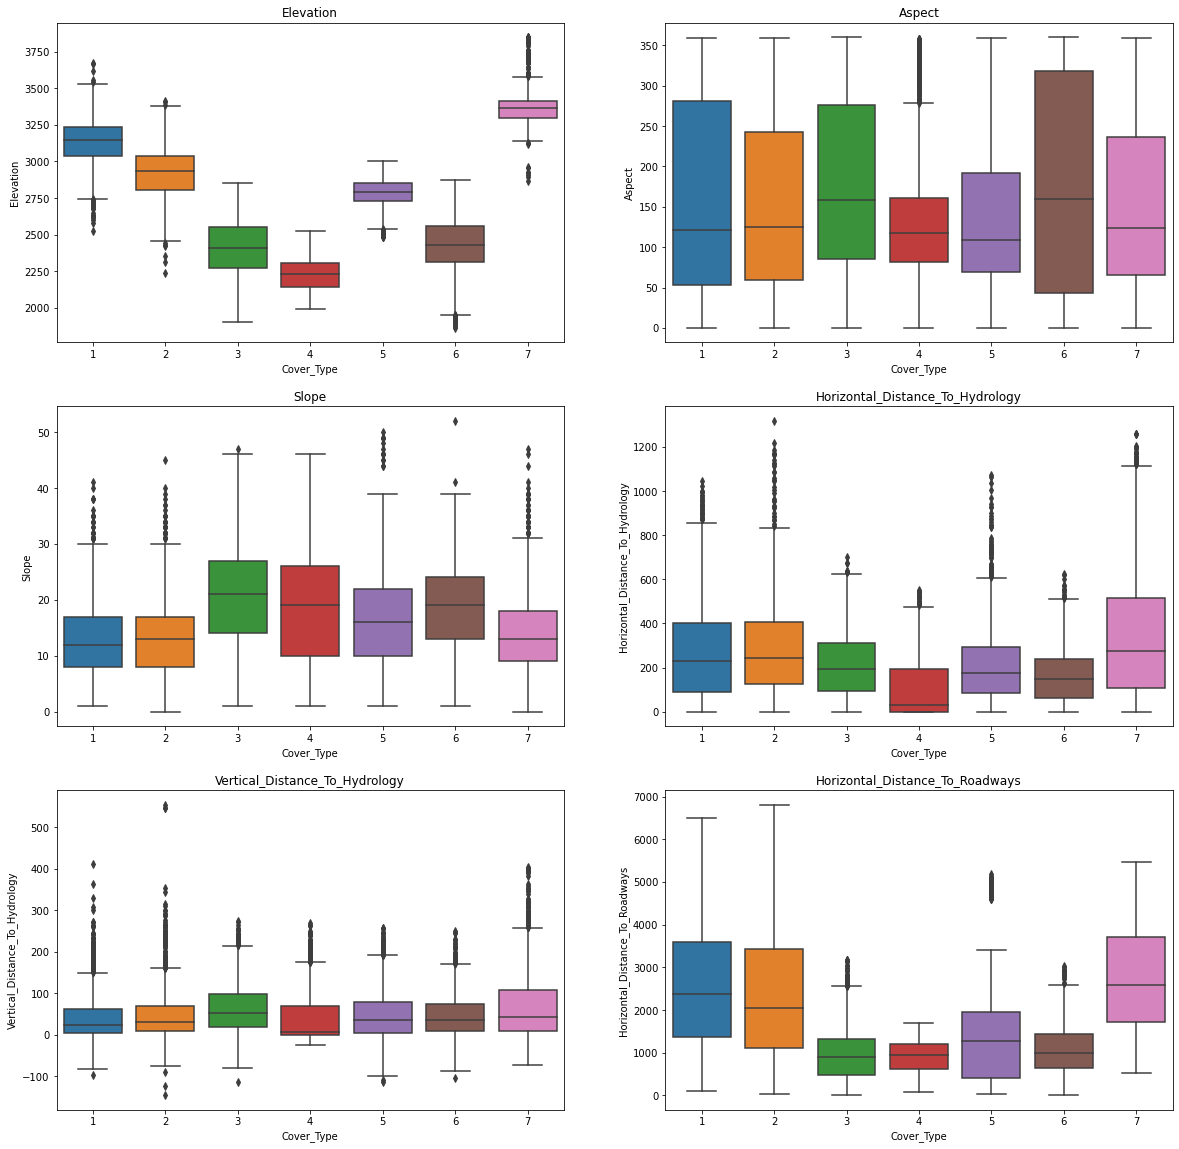

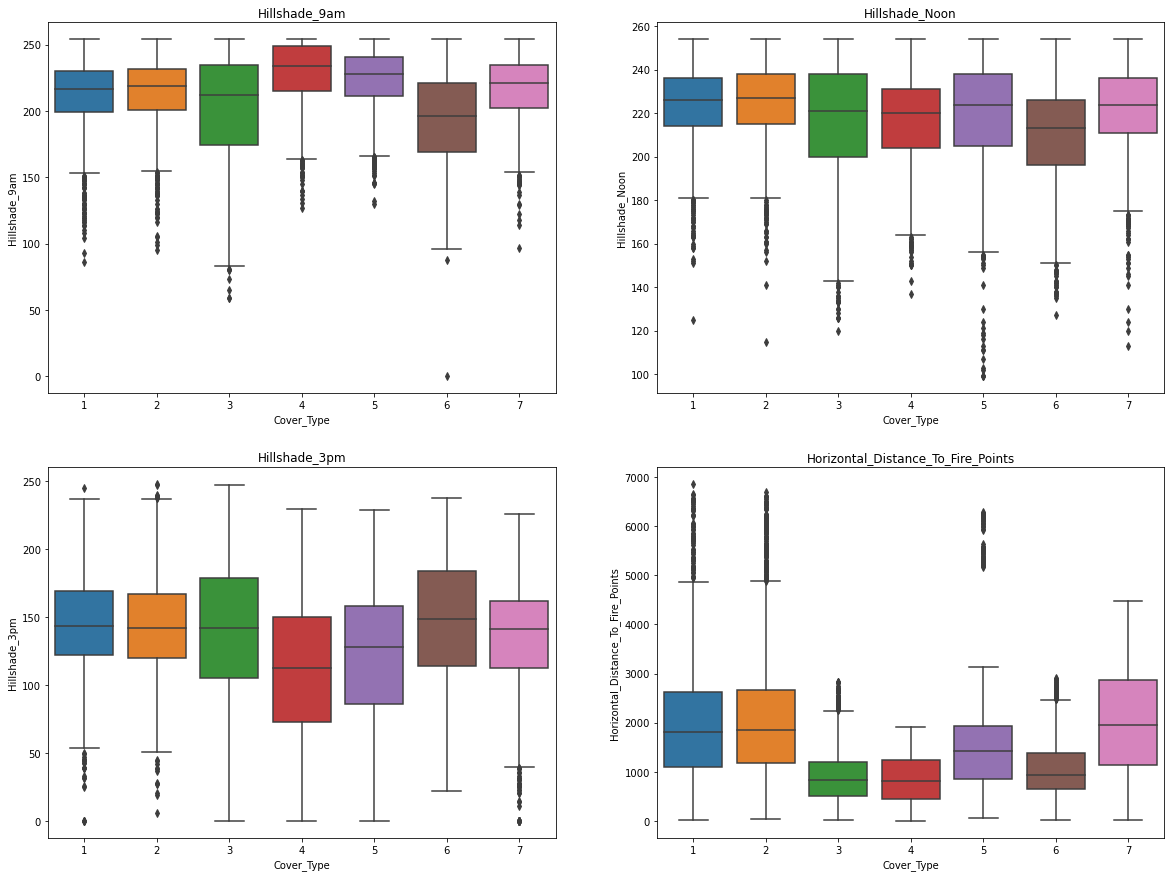

In [104]:
# plot boxplots of each cover type across first 10 feature values (excluding wilderness and soil type binary columns)
# splitting into two figures due to formatting issues

# get list of columns
columns_to_plot = list(train_df.columns[1:11])
columns_to_plot

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Chart 1 (first 6 columns)

# create axis
fig, axs = plt.subplots(3, 2, figsize=(20, 20))
axis_x = [0,0,1,1,2,2,3,3,4,4]
axis_y = [0,1,0,1,0,1,0,1,0,1]

# plot each column boxplot
# use axis_x & axis_y to define which axis to plot onto
for index, col in enumerate(columns_to_plot[0:6]):
    
    x = axis_x[index]
    y = axis_y[index]
    
    sns.boxplot(x='Cover_Type', y=col, data=train_df, ax = axs[x,y])
    axs[x,y].set_title(col)

plt.show()

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Chart 2 (remaining 4 columns)

# create axis
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
axis_x = [0,0,1,1,2,2]
axis_y = [0,1,0,1,0,1]

# plot each column boxplot
# use axis_x & axis_y to define which axis to plot onto
for index, col in enumerate(columns_to_plot[6:]):
    
    x = axis_x[index]
    y = axis_y[index]
    
    sns.boxplot(x='Cover_Type', y=col, data=train_df, ax = axs[x,y])
    axs[x,y].set_title(col)

plt.show()

At first glance, elevation variable has the most variability across cover types. Some cover type pairs emerge with similar characteristics. For example, cover type 1 & 2 seem to have similar thresholds in addition cover types 3 & 4. 

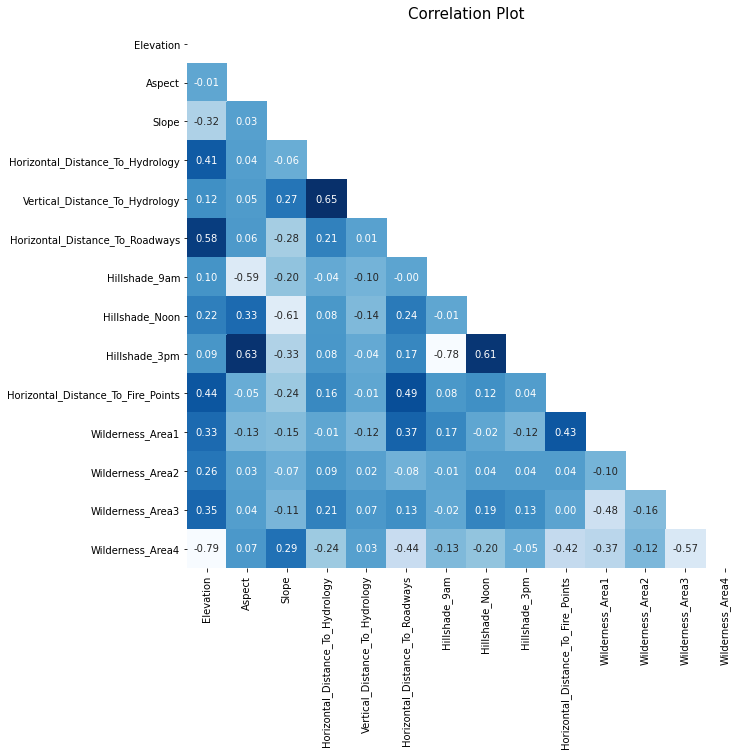

In [103]:
# correlation plot
corr = train_df.iloc[:, 1:15].corr()

# make mask (only plot lower left triangle)
mask = np.ones_like(corr,dtype = np.bool)
mask = np.triu(mask)

# plot the heatmap
fig, ax = plt.subplots(figsize=(10,10))         
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        mask = mask,
        annot=True, 
        fmt='.2f',
        cmap="Blues",
        cbar=False)

plt.title('Correlation Plot',size=15)
plt.show()
pass

No extreme intercorellation among features, but several coefficients with an absolute value above 0.5. There might be a benefit to use dimensionality reduction or other types of feature engineering to consolidate the features. 

### Plot Binary Variables

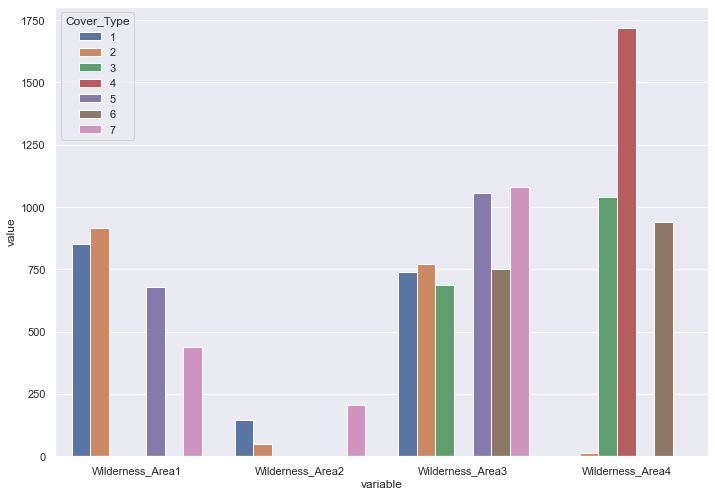

In [119]:
# sumarize counts per wilderness flag per cover type  

# get wilderness columns
wild_cols = [col for col in train_df.columns if 'Wilderness' in col]
wild_cols += ['Cover_Type']

# summarize wilderness column counts by cover type
wilderness_cover_type = train_df[wild_cols].groupby(['Cover_Type']).sum()
wilderness_cover_type = wilderness_cover_type.reset_index()

# make table longer for easier plotting
wilderness_cover_type = pd.melt(wilderness_cover_type, id_vars=['Cover_Type'])

# Plot wilderness counts
sns.set(rc={'figure.figsize':(11.7,8.27)})   
sns.barplot(x='variable', y='value', hue="Cover_Type", data=wilderness_cover_type)
plt.show()

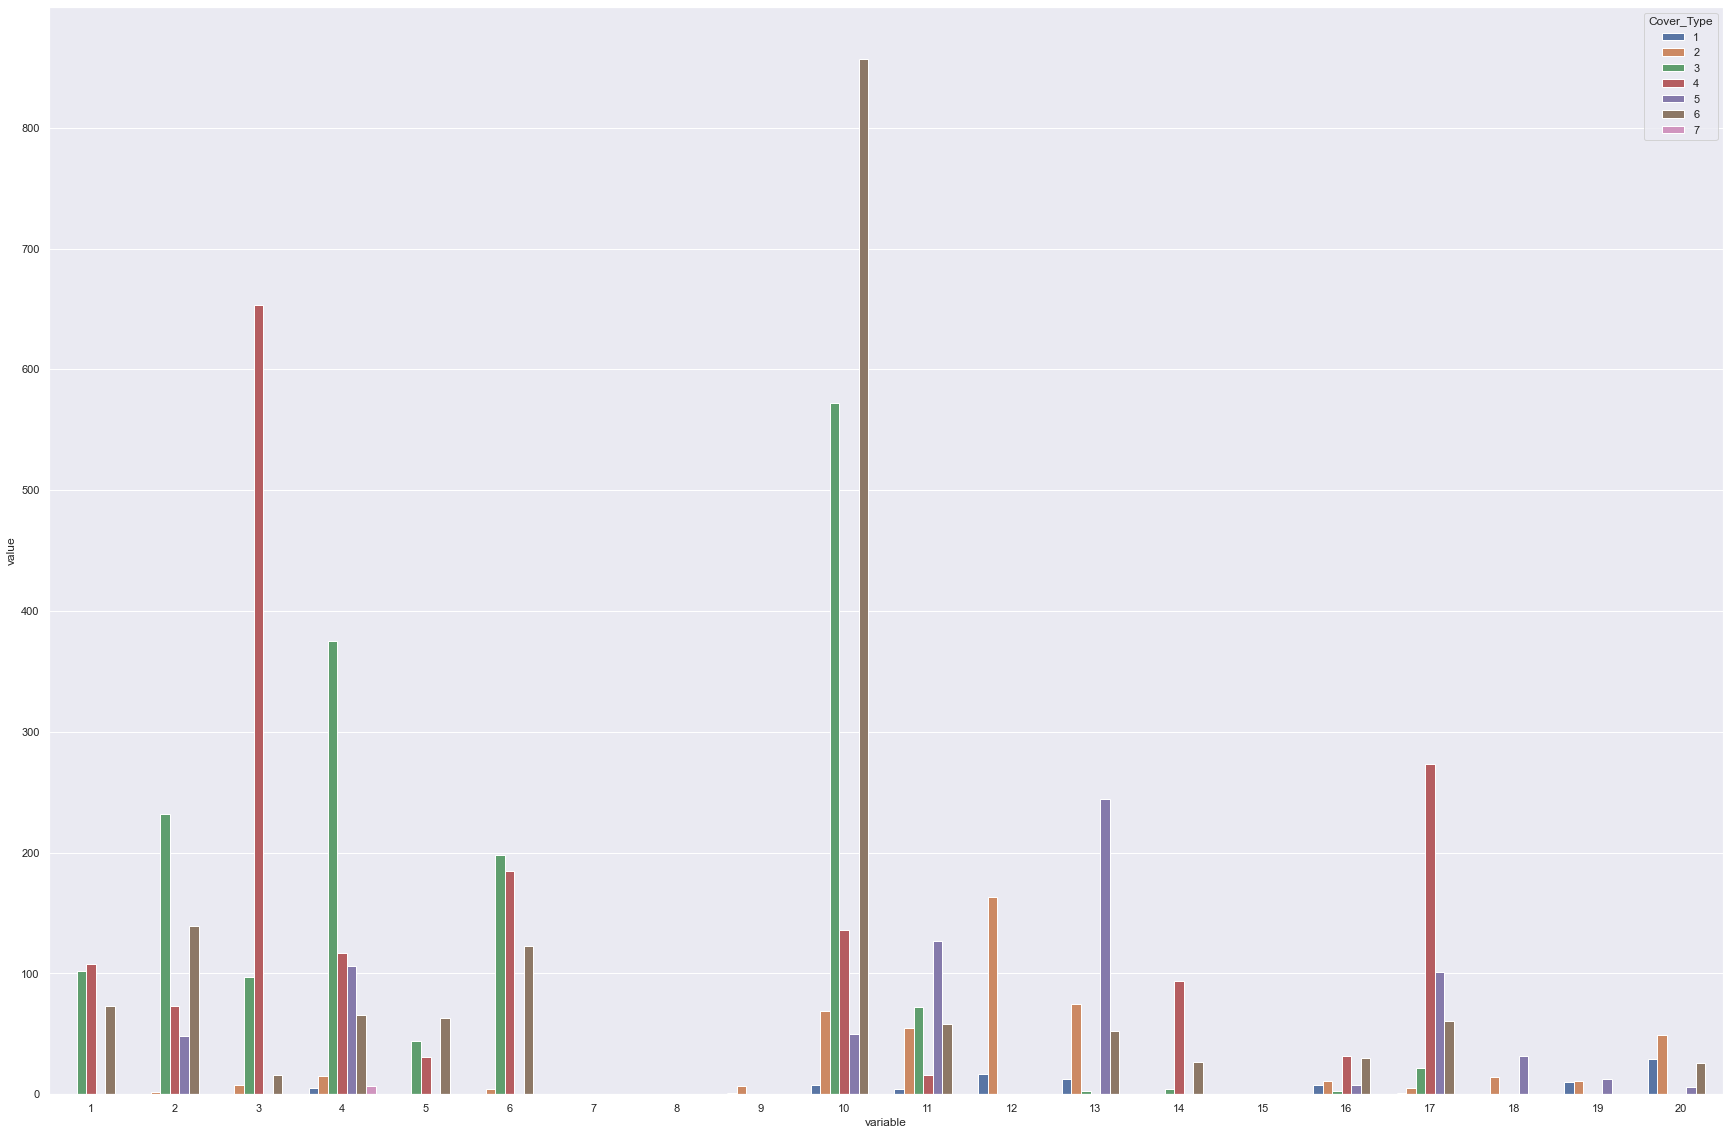

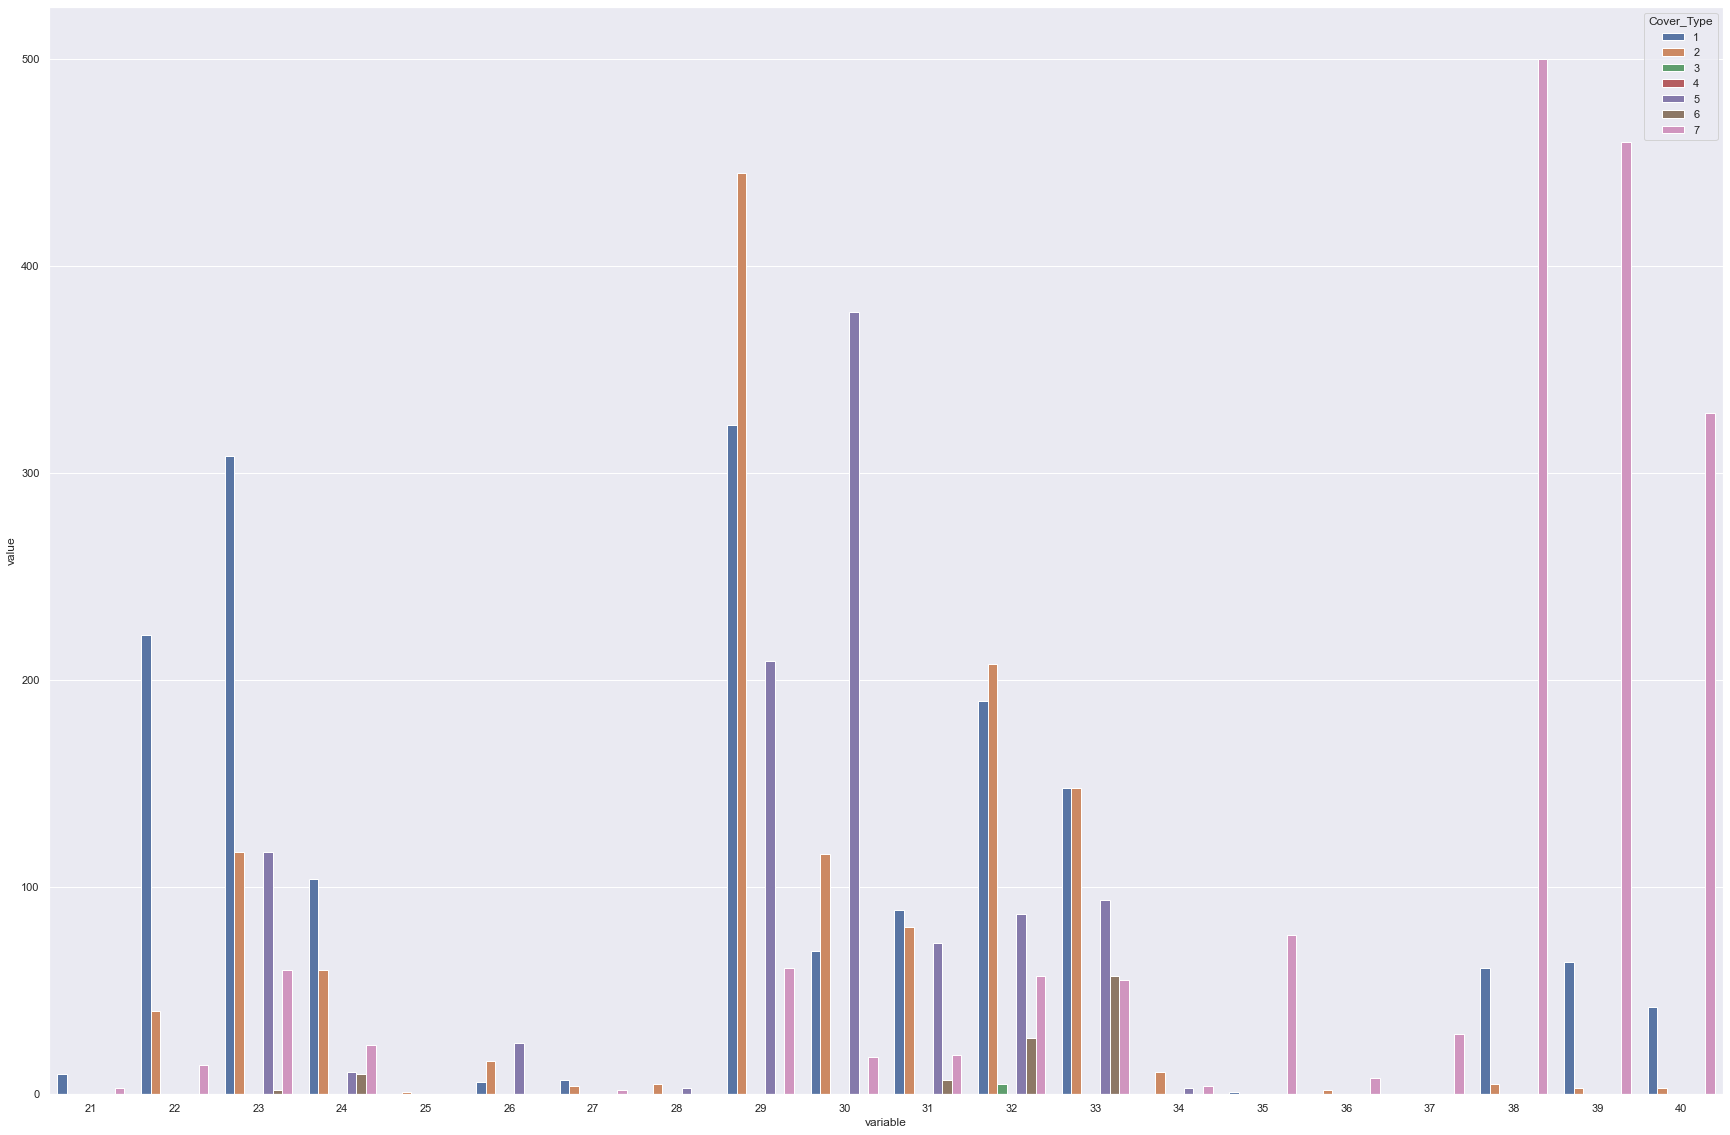

In [123]:
# sumarize counts per soil flag per cover type  

# get soil columns
soil_cols = [col for col in train_df.columns if 'Soil' in col]
soil_cols += ['Cover_Type']

# summarize wilderness column counts by cover type
soil_cover_type = train_df[soil_cols].groupby(['Cover_Type']).sum()
soil_cover_type = soil_cover_type.reset_index()

# make long format
soil_cover_type = pd.melt(soil_cover_type, id_vars=['Cover_Type'])

# remove text from soil_type and extract integer value
soil_cover_type['variable'] = soil_cover_type['variable'].str.extract('(\d+)').astype(int)

soil_cover_type_1 = soil_cover_type[soil_cover_type['variable'] <= 20]
soil_cover_type_2 = soil_cover_type[soil_cover_type['variable'] > 20]


# plotting; separate in 2 due to high number of columns
# plot 1
sns.set(rc={'figure.figsize':(30,20)})  
sns.barplot(x='variable', y='value', hue="Cover_Type", data=soil_cover_type_1)
plt.show()

# plot 2
sns.set(rc={'figure.figsize':(30,20)})  
sns.barplot(x='variable', y='value', hue="Cover_Type", data=soil_cover_type_2)
plt.show()

The frequency counts highlight the sparsity of the binary flags, but also show some patterns where certain cover types are concentrated across specific ones. For instance, wilderness area 4 is primarily cover type 4. Another example is how cover type 7 largely has soil types 36-40. 

# 3) Baseline Models

We tested a total of 4 different classifiers. For each we fit the model on the `train_data` and generalized on the `dev_data`. The `test_data` from the kaggle website doesn't contain any class labels.
- K-nn: accuracy of ~**85.6%**
- Bernoulli Naive Bayes: accuracy of ~**60.5%**
- Gaussian Naive Bayes: accuracy of ~**64.2%**
- Logistic Regression: accuracy of ~**63%-65%**

K-Nearest Neighbors accuracy = 80.45634920634922


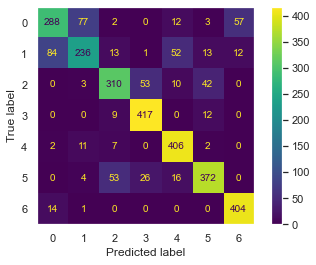


Logistic Regression accuracy = 37.99603174603175


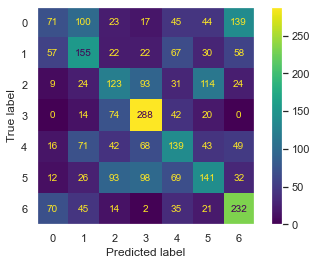


Gaussian Naive Bayes accuracy = 64.74867724867724


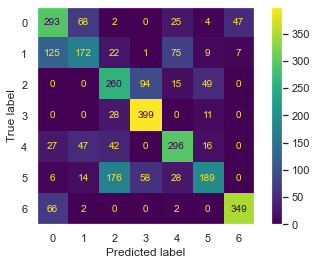


Random Forest accuracy = 86.01190476190477


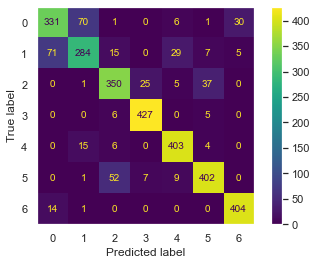


Extra Trees accuracy = 86.44179894179894


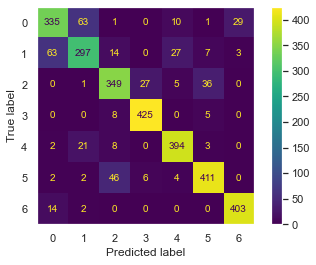

In [155]:
def plot_confusion_matrix(dev_labels, pred_labels):
    cm = confusion_matrix(dev_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp = disp.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')
    plt.grid(False)
    plt.show()
    return

def baseline_models(
    train_data=train_data, 
    train_labels=train_labels, 
    dev_data=dev_data, 
    dev_labels=dev_labels,
    show_confusion_matrix=True):
    import warnings
    warnings.filterwarnings("ignore")

    # K-Nearest Neighbors
    knn = KNeighborsClassifier()
    knn.fit(train_data, train_labels)
    print(f'K-Nearest Neighbors accuracy = {(knn.score(dev_data, dev_labels)*100)}')
    pred_labels  = knn.predict(dev_data)
    if show_confusion_matrix == True:
        plot_confusion_matrix(dev_labels, pred_labels)


    # Logistic Regression
    lm = LogisticRegression() 
    lm.fit(train_data, train_labels)
    print(f'\nLogistic Regression accuracy = {(lm.score(dev_data, dev_labels)*100)}')
    pred_labels  = lm.predict(dev_data)
    if show_confusion_matrix == True:
        plot_confusion_matrix(dev_labels, pred_labels)

    # Gaussian Naive Bayes
    gnb = GaussianNB()
    gnb.fit(train_data, train_labels)
    print(f'\nGaussian Naive Bayes accuracy = {(gnb.score(dev_data, dev_labels)*100)}')
    pred_labels  = gnb.predict(dev_data)
    if show_confusion_matrix == True:
        plot_confusion_matrix(dev_labels, pred_labels)

    # Random Forest
    rf = RandomForestClassifier(random_state=0)
    rf.fit(train_data, train_labels)
    print(f'\nRandom Forest accuracy = {(rf.score(dev_data, dev_labels)*100)}')
    pred_labels  = rf.predict(dev_data)
    if show_confusion_matrix == True:
        plot_confusion_matrix(dev_labels, pred_labels)

    # ExtraTrees
    et = ExtraTreesClassifier(random_state=0)
    et.fit(train_data, train_labels)
    print(f'\nExtra Trees accuracy = {(et.score(dev_data, dev_labels)*100)}')
    pred_labels  = et.predict(dev_data)
    if show_confusion_matrix == True:
        plot_confusion_matrix(dev_labels, pred_labels)
    
    return

baseline_models()

## KNN

KNN accuracy at i=1 : 0.84755291005291
KNN accuracy at i=2 : 0.8250661375661376
KNN accuracy at i=3 : 0.8247354497354498
KNN accuracy at i=4 : 0.8095238095238095
KNN accuracy at i=5 : 0.8045634920634921
KNN accuracy at i=6 : 0.7999338624338624


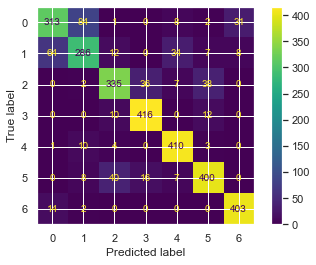

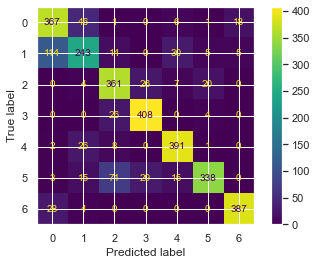

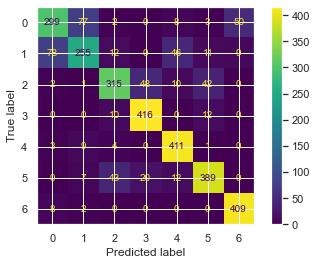

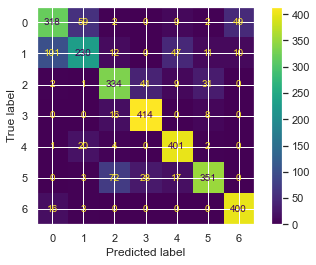

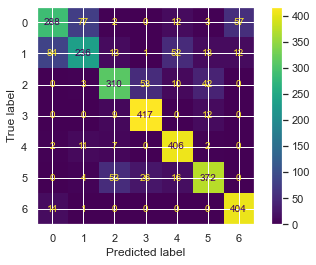

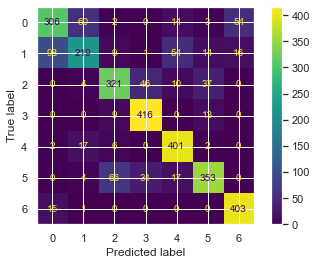

In [46]:
def knn():
    for i in range(1, 7):
        knn = KNeighborsClassifier(n_neighbors=i)

        knn.fit(train_data, train_labels) #train on processed train data

        pred_knn  = knn.predict(dev_data) #predict on dev data

        accuracy_count_knn = 0

        for j in range(pred_knn.shape[0]):
            if pred_knn[j] == dev_labels[j]:
                accuracy_count_knn += 1
            else:
                continue

        print(f'KNN accuracy at i={i} : {(accuracy_count_knn/pred_knn.shape[0])}')

        cm = confusion_matrix(dev_labels, pred_knn)

        ConfusionMatrixDisplay(cm).plot()
    
#     ########## just type 1 and 2 ##########
    
#     for i in range(1,7):
#         print(f'i = {i}')
#         knn_1_2 = KNeighborsClassifier(n_neighbors=i)

#         train_data_1_2 = train_data[(train_labels == 1) | (train_labels == 2)]
#         train_labels_1_2 = train_labels[(train_labels == 1) | (train_labels == 2)]

#         dev_data_1_2 = dev_data[(dev_labels == 1) | (dev_labels == 2)]
#         dev_labels_1_2 = dev_labels[(dev_labels == 1) | (dev_labels == 2)]

#         pred_knn_1_2_data = dev_data[(pred_knn == 1) | (pred_knn == 2)]
#         pred_knn_1_2_actual_labels = dev_labels[(pred_knn == 1) | (pred_knn == 2)]

#         knn_1_2.fit(train_data_1_2, train_labels_1_2)

#         pred_knn_1_2  = knn_1_2.predict(pred_knn_1_2_data) #predict on dev data

#         accuracy_count_knn_1_2 = 0

#         for j in range(pred_knn_1_2.shape[0]):
#             if pred_knn_1_2[j] == pred_knn_1_2_actual_labels[j]:
#                 accuracy_count_knn_1_2 += 1
#             else:
#                 continue

#         print("KNN accuracy with no filtering: " + str (accuracy_count_knn_1_2/pred_knn_1_2.shape[0]))

#         cm_1_2 = confusion_matrix(pred_knn_1_2_actual_labels, pred_knn_1_2)

#         ConfusionMatrixDisplay(cm_1_2).plot()
    
      
knn()

## Bernoulli NB w/ Grid Search

In [10]:
def bernoulli_nb(alphas):

    # BernoulliNB training
    model_nb = BernoulliNB()
    model_nb.fit(train_data, train_labels)

    # use cros validation = 5 to validate the alphas
    model_cv = GridSearchCV(estimator=model_nb, param_grid=alphas, cv=5, scoring='accuracy')
    model_cv.fit(train_data, train_labels)

    # create the data frame
    params = [param['alpha'] for param in model_cv.cv_results_["params"]]
    mean_test_score = model_cv.cv_results_["mean_test_score"]
    std_test_score = model_cv.cv_results_["std_test_score"]
    df = pd.DataFrame(list(zip(params, mean_test_score,std_test_score)),
                   columns =['alpha', 'mean_test_score',"std_test_score"])
    print(df)
    
alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
bernoulli_nb(alphas)

          alpha  mean_test_score  std_test_score
0  1.000000e-10         0.595607        0.012450
1  1.000000e-04         0.595607        0.012450
2  1.000000e-03         0.595607        0.012450
3  1.000000e-02         0.595607        0.012450
4  1.000000e-01         0.595680        0.012555
5  5.000000e-01         0.595754        0.012449
6  1.000000e+00         0.595754        0.012655
7  2.000000e+00         0.595533        0.012278
8  1.000000e+01         0.592226        0.012280


## Gaussian & Bernoulli Naive Bayes

In [11]:
def gaussian_nb():


    ####Train on GaussianNB with no var_smoothing####
    model_gnb = GaussianNB()
    model_gnb.fit(train_data,train_labels)

    sigmas = model_gnb.sigma_
    thetas = model_gnb.theta_

    ## predict on dev data

    pred_gnb = model_gnb.predict(dev_data)
    accuracy_count_gnb = 0


    ###generate accuracy
    for j in range(dev_labels.shape[0]):
        if pred_gnb[j] == dev_labels[j]:
            accuracy_count_gnb += 1
        else:
            continue

    print("GaussianNB accuracy w/ no modification: " + str(accuracy_count_gnb/pred_gnb.shape[0]))

    ###Train on gaussianNB with var_smoothing = .1###

    model_gnb_s = GaussianNB(var_smoothing=.1)
    model_gnb_s.fit(train_data,train_labels)

    sigmas2 = model_gnb_s.sigma_
    thetas2 = model_gnb_s.theta_


    ## predict on dev data

    pred_gnb_s = model_gnb_s.predict(dev_data)
    accuracy_count_gnb_s = 0


    ###generate accuracy
    for j in range(dev_labels.shape[0]):
        if pred_gnb_s[j] == dev_labels[j]:
            accuracy_count_gnb_s += 1
        else:
            continue

    print("GaussianNB accuracy w/ var smoothing @ .1: " + str(accuracy_count_gnb_s/pred_gnb_s.shape[0]))

    #train on bernoulliNB

    model_gnb_s2 = BernoulliNB()
    model_gnb_s2.fit(train_data,train_labels)

    pred_gnb_s2 = model_gnb_s2.predict(dev_data)
    accuracy_count_gnb_s2 = 0

    for j in range(dev_labels.shape[0]):
        if pred_gnb_s2[j] == dev_labels[j]:
            accuracy_count_gnb_s2 += 1
        else:
            continue

    print("Bernoulli NB performance: " + str(accuracy_count_gnb_s2/pred_gnb_s2.shape[0]))


    
gaussian_nb()

GaussianNB accuracy w/ no modification: 0.6421957671957672
GaussianNB accuracy w/ var smoothing @ .1: 0.3055555555555556
Bernoulli NB performance: 0.6058201058201058


## Logistic Regression

In [12]:

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# logistic regression

logistic_result = {}
logistic_result_weights = {}
c_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1]

for c in c_values:
    model_logistic = LogisticRegression(C = c, solver="liblinear", multi_class="auto")
    model_logistic.fit(train_data, train_labels)
    model_logistic_pred = model_logistic.predict(dev_data)
    logistic_result[c] = metrics.accuracy_score(dev_labels, model_logistic_pred)

# find best c
best_c = max(logistic_result, key=logistic_result.get)

# build dataframe of f1_score at different c values
logistic_result_df = pd.DataFrame(data = zip(c_values,list(logistic_result.values())), columns = ['c','accuracy'])
logistic_result_df['regularization'] = 1 / np.array(c_values)

# print results
print('Logistic Regression Classifier:')
print('-'*50)
print(f'Best "c" in logistic regression is: c={best_c}, F1 score={round(logistic_result[best_c],3)}')
print()
print(logistic_result_df[['c','regularization','accuracy']])

Logistic Regression Classifier:
--------------------------------------------------
Best "c" in logistic regression is: c=0.5, F1 score=0.653

      c  regularization  accuracy
0   0.1       10.000000  0.645503
1   0.2        5.000000  0.649471
2   0.3        3.333333  0.644841
3   0.4        2.500000  0.644180
4   0.5        2.000000  0.652778
5   0.6        1.666667  0.642196
6   0.7        1.428571  0.640212
7   0.8        1.250000  0.639550
8   0.9        1.111111  0.638889
9   1.0        1.000000  0.640873
10  1.1        0.909091  0.641534


# 4) Generalize Step Optimization

### Feature Engineering

pca on soil_types

In [128]:
# get feature indexes for Soil_Types
other_idx = [i for i, col in enumerate(train.columns) if not 'Soil' in col and 'Cover' not in col]
soil_type_idx = [i for i, col in enumerate(train.columns) if 'Soil' in col]

soil_type_features = train_data[:, soil_type_idx]
other_features = train_data[:, other_idx]

In [115]:
# a handy function for vizualizing principle components as a heatmap
# this allows you to see what dimensions in the 'original space' are
# active

def visualize_pca_comps_heatmap(plot, comps, alpha=None):
    heatmap = plot.pcolor(comps, cmap=plt.cm.Blues)
    

    x_lab = [i for i in range(comps.shape[1])]
    y_lab = [i for i in (range(comps.shape[0]))]
    
    plot.set_xticks(np.arange(comps.shape[1])+0.5, minor=False)
    plot.set_yticks(np.arange(comps.shape[0])+0.5, minor=False)
    
    # want a more natural, table-like display
    plot.invert_yaxis()
    
    plot.set_xticklabels(x_lab, minor=False)
    plot.set_yticklabels(y_lab, minor=False)
    
    if alpha is not None:
        plt.title(f'Heatmap of Sparse PCA (alpha {alpha}) components Rows: components, Cols: Original dimensions. ')
    else:
        plt.title('Heatmap of PCA components Rows: components, Cols: Original dimensions')

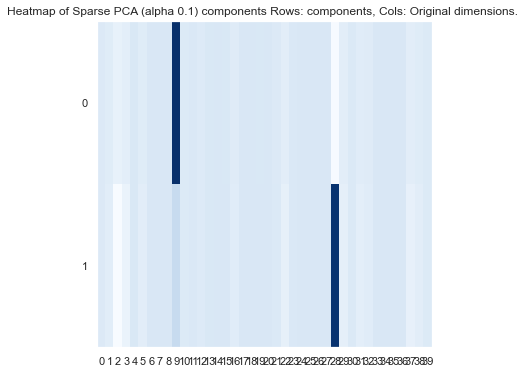

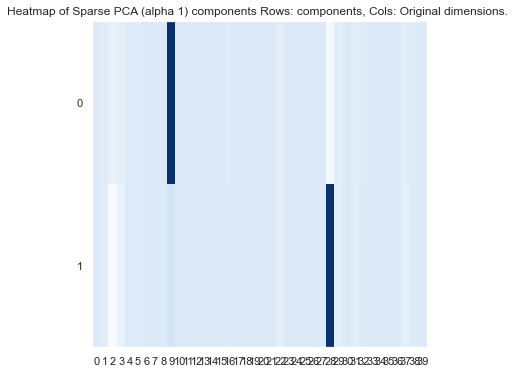

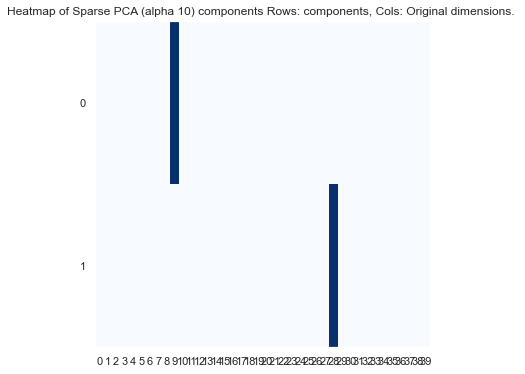

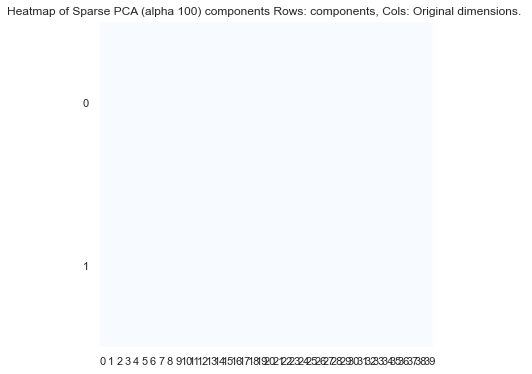

In [121]:
def pca_testing():
    # change alpha and watch as dimensions get dropped
    n_comp = 2
    
    ###############
    plt.figure(figsize=(6, 6))
    alpha_set = 0.1
    spca = SparsePCA(n_components = n_comp, alpha=alpha_set, tol=0.1) # always done now, depreciated #, normalize_components=True)
    spca.fit(soil_type_features)
    p2 = plt.subplot(1, 1, 1)
    visualize_pca_comps_heatmap(p2, spca.components_, alpha_set)
    ###############

    ###############
    plt.figure(figsize=(6, 6))
    alpha_set = 1
    spca = SparsePCA(n_components = n_comp, alpha=alpha_set, tol=0.1) # always done now, depreciated #, normalize_components=True)
    spca.fit(soil_type_features)
    p2 = plt.subplot(1, 1, 1)
    visualize_pca_comps_heatmap(p2, spca.components_, alpha_set)
    ###############

    ###############
    plt.figure(figsize=(6, 6))
    alpha_set = 10
    spca = SparsePCA(n_components = n_comp, alpha=alpha_set, tol=0.1) # always done now, depreciated #, normalize_components=True)
    spca.fit(soil_type_features)
    p2 = plt.subplot(1, 1, 1)
    visualize_pca_comps_heatmap(p2, spca.components_, alpha_set)
    ###############

    ###############
    plt.figure(figsize=(6, 6))
    alpha_set = 100
    spca = SparsePCA(n_components = n_comp, alpha=alpha_set, tol=0.1) # always done now, depreciated #, normalize_components=True)
    spca.fit(soil_type_features)
    p2 = plt.subplot(1, 1, 1)
    visualize_pca_comps_heatmap(p2, spca.components_, alpha_set)
    ###############

pca_testing()

In [178]:
def split_soil_type_features(dataset):
    # get feature indexes for Soil_Types
    other_idx = [i for i, col in enumerate(train.columns) if not 'Soil' in col and 'Cover' not in col]
    soil_type_idx = [i for i, col in enumerate(train.columns) if 'Soil' in col]
    
    soil_type_features = dataset[:, soil_type_idx]
    other_features = dataset[:, other_idx]
    
    return other_features, soil_type_features

In [182]:
def spca_n_comp_trials():
    print('without spca:')
    baseline_models(
            train_data=train_data, 
            train_labels=train_labels, 
            dev_data=dev_data,
            dev_labels=dev_labels,
            show_confusion_matrix=False
        )
    
    for alpha_set in [1,10,100]:
        for n_comp in range(1,6):
            print()
            print('-'*25)
            print(f'number of components = {n_comp}. alpha = {alpha_set}')

            ##### transform train_data #####
            other_features, soil_type_features = split_soil_type_features(train_data)
            spca = SparsePCA(n_components = n_comp, alpha=alpha_set, tol=0.1) # always done now, depreciated #, normalize_components=True)
            spca_soil_features = spca.fit_transform(soil_type_features)
            spca_transformed_train_data = np.concatenate((other_features, spca_soil_features), axis=1)

            ##### transform dev_data #####
            other_features, soil_type_features = split_soil_type_features(dev_data)
            spca = SparsePCA(n_components = n_comp, alpha=alpha_set, tol=0.1) # always done now, depreciated #, normalize_components=True)
            spca_soil_features = spca.fit_transform(soil_type_features)
            spca_transformed_dev_data = np.concatenate((other_features, spca_soil_features), axis=1)

            baseline_models(
                train_data=spca_transformed_train_data, 
                train_labels=train_labels, 
                dev_data=spca_transformed_dev_data,
                dev_labels=dev_labels,
                show_confusion_matrix=False
            )
    return

spca_n_comp_trials()

without spca:
K-Nearest Neighbors accuracy = 80.45634920634922

Logistic Regression accuracy = 37.99603174603175

Gaussian Naive Bayes accuracy = 64.74867724867724

Random Forest accuracy = 86.01190476190477

Extra Trees accuracy = 86.44179894179894

-------------------------
number of components = 1. alpha = 1
K-Nearest Neighbors accuracy = 80.45634920634922

Logistic Regression accuracy = 38.55820105820106

Gaussian Naive Bayes accuracy = 60.945767195767196

Random Forest accuracy = 85.3505291005291

Extra Trees accuracy = 85.3505291005291

-------------------------
number of components = 2. alpha = 1
K-Nearest Neighbors accuracy = 80.45634920634922

Logistic Regression accuracy = 38.62433862433862

Gaussian Naive Bayes accuracy = 62.00396825396825

Random Forest accuracy = 83.82936507936508

Extra Trees accuracy = 83.53174603174604

-------------------------
number of components = 3. alpha = 1
K-Nearest Neighbors accuracy = 80.45634920634922

Logistic Regression accuracy = 38.425925

KeyboardInterrupt: 

binarize or trinarize features to reduce complexity?

### Hyperparameters

### multiple models to differentiate problem classes

# 5) Model Comparision

# 6) Conclusion

# 7) Appendix

- Git repository [[link](https://github.com/sams-data/mids-w207_9_sp22_forest_cover_classification/blob/main/README.md)]